# FWI Example
We will peform FWI using the following steps:
1. Prepare models
    * Read the true model from binary file
    * Generate our subsampled true and initial models 
2. Create list of shot locations 
3. Create a method that builds a single shot gather
4. Use the method in 3. to create data for both models
6. Visualize data
7. Assess if data is cycle skipped at the farthest offsets
8. Build the gradient/cost function for Optim.jl
9. Perform the FWI using `Optim.jl`
10. Visualize velocity models and objective function
11. Visualize data match 
12. Write models to local disk

First, specify the storage account that you want to use, the name of the scale-set, and the scale-set template used by AzManagers.

In [1]:
storageaccount="mystorageaccount"
scalesetname="myscalesetname"
scalesettemplate="myscalesettemplate"

"cbox32"

In [2]:
using AzManagers, AzSessions, AzStorage, CloudSeis, Distributed, DistributedOperations, Jets, JetPack, JetPackDSP, JetPackWaveFD, LinearAlgebra, LineSearches, Logging, Optim, PyPlot, Printf, Schedulers, WaveFD

In [8]:
global_logger(ConsoleLogger(stdout, Logging.Info))

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(0x0000002c) open, 0 bytes waiting))), Info, Logging.default_metafmt, true, 0, Dict{Any,Int64}())

## 1. Prepare models

#### Read true model from binary file

In [9]:
v = read!("../20_marmousi_model_setup/marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176,851));

#### Subsample models
We are running a low frequency FWI, so we resample the model from a 20m grid to a 40m grid so that the modeling will run faster.

In [10]:
v = v[1:2:end,1:2:end]

dz,dx = 40.0,40.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (40.0, 40.0)
(nz, nx) = (88, 426)


#### Smooth the true model to generate true and initial models
Note that we will perform this FWI example at low frequency, and so we smooth both the true and the initial models before we begin. 

Please refer to the smoothing notebook in the `20_marmousi_model_setup` example directory for more details on our smoothing approach. Note that we apply the smoothing in slowness to preserve traveltime.

In [11]:
# smoothing for the true model
ns1 = 1
P1 = JopPad(JetSpace(Float32,nz,nx), -ns1:nz+ns1, -ns1:nx+ns1, extend=true)
S1 = JopConvolve(range(P1), smoother=:rect, n=(ns1,ns1))
R1 = JopPad(JetSpace(Float32,nz,nx), -ns1:nz+ns1, -ns1:nx+ns1, extend=false)
s1 = R1' ∘ S1 ∘ P1 * (1 ./ v)
v1 = 1 ./(s1);

# smoothing for the initial model
ns2 = 5
P2 = JopPad(JetSpace(Float32,nz,nx), -ns2:nz+ns2, -ns2:nx+ns2, extend=true)
S2 = JopConvolve(range(P2), smoother=:rect, n=(ns2,ns2))
R2 = JopPad(JetSpace(Float32,nz,nx), -ns2:nz+ns2, -ns2:nx+ns2, extend=false)
s2 = R2' ∘ S2 ∘ P2 * (1 ./ v)
v2 = 1 ./(s2);

#### Replace the water layer in both models

In [12]:
v1[v.==1500.0] .= 1500.0;
v2[v.==1500.0] .= 1500.0;

#### Visualize

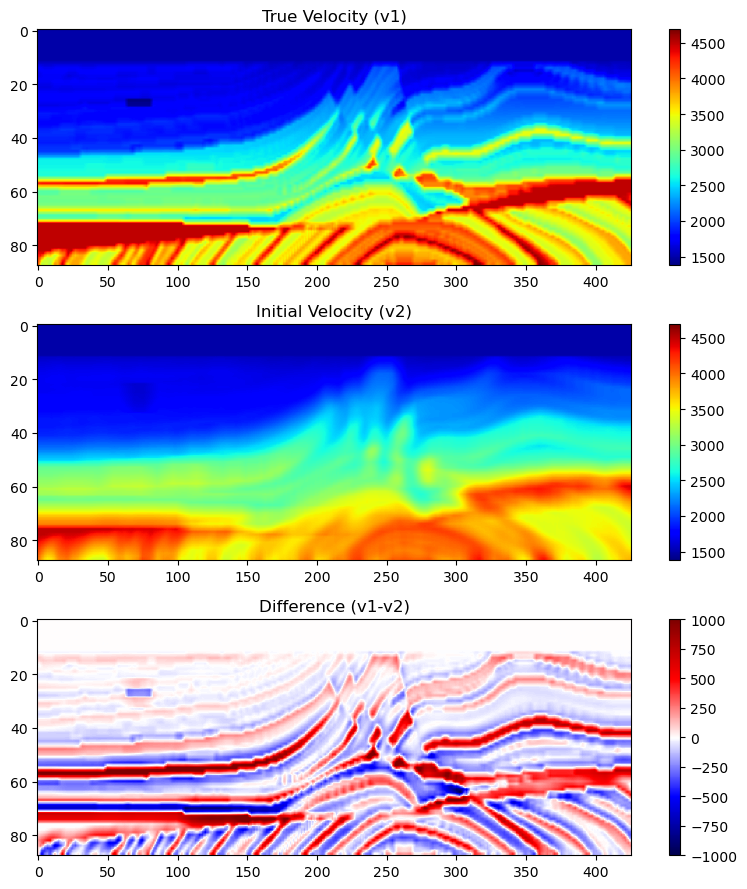

In [13]:
figure(figsize=(8,9))
vmin,vmax = extrema(v1)
dmin,dmax = -1000,1000

subplot(3,1,1); imshow(v1,aspect="auto",cmap="jet"); 
colorbar(); clim(vmin,vmax); title("True Velocity (v1)")

subplot(3,1,2); imshow(v2,aspect="auto",cmap="jet");
colorbar(); clim(vmin,vmax); title("Initial Velocity (v2)");

subplot(3,1,3); imshow(v1.-v2,aspect="auto",cmap="seismic");
colorbar(); clim(dmin,dmax); title("Difference (v1-v2)");

tight_layout()

## 3. Create list of shot locations 
We use 16 shot locations evenly distributed across the top of the model.

In [14]:
sx = round.(Int,collect(range(0,stop=(nx-1)*dx,length=16)))

16-element Array{Int64,1}:
     0
  1133
  2267
  3400
  4533
  5667
  6800
  7933
  9067
 10200
 11333
 12467
 13600
 14733
 15867
 17000

## 4. Build `F`, the distributed block operator for seismic modeling

## 5. Create the data in both models

In [15]:
function build_data(ishot, dataset, sx, _v, dz, dx)
    io = csopen(dataset, "r+")

    v = localpart(_v)
    nz,nx = size(v)
    
    F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = Sys.CPU_THREADS,
        ntrec = size(io,1),
        dtrec = pincs(io,1),
        dtmod = 0.002,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=4.0),
        sx = sx[ishot],
        sz = dz,
        rx = dx*[0:nx-1;],
        rz = 2*dz*ones(length(0:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        srcfieldfile = "",
        reportinterval=0)
    
    h = allocframehdrs(io)
    for itrace = 1:nx
        set!(prop(io, "SOU_X"), h, itrace, state(F).sx[1])
        set!(prop(io, "REC_X"), h, itrace, state(F).rx[itrace])
        set!(prop(io, "SOU_ELEV"), h, itrace, -state(F).sz[1])
        set!(prop(io, "REC_ELEV"), h, itrace, -state(F).rz[itrace])
        set!(prop(io, "TRC_TYPE"), h, itrace, tracetype[:live])
        set!(prop(io, "FRAME"), h, itrace, ishot)
        set!(prop(io, "TRACE"), h, itrace, itrace)
    end
    writeframe(io, F*v, h)
    close(io)
    close(F)
    nothing
end

build_data (generic function with 1 method)

In [16]:
container1 = AzContainer("examples/marmousi/data-1-cs";storageaccount=storageaccount)
container2 = AzContainer("examples/marmousi/data-2-cs";storageaccount=storageaccount)

AzContainer{AzSessions.AzDeviceCodeFlowSession}("samkaplan0", "examples", "marmousi/data-2-cs", Azure device code flow credentials session, 16, 10, 0)

In [ ]:
tracepropertydefs = [stockprop[:SOU_X], stockprop[:REC_X], stockprop[:SOU_ELEV], stockprop[:REC_ELEV]]

cscreate(container1; axis_lengths=[2501,nx,16], axis_pincs=[0.004,1.0,1.0], frames_per_extent=1, tracepropertydefs=tracepropertydefs)
cscreate(container2; axis_lengths=[2501,nx,16], axis_pincs=[0.004,1.0,1.0], frames_per_extent=1, tracepropertydefs=tracepropertydefs)

In [ ]:
_v1 = ArrayFutures(v1)
epmap(build_data, 1:length(sx), container1, sx, _v1, dz, dx;
        epmap_addprocs = n->addprocs(scalesettemplate, n; group=scalesetname, env=Dict("OMP_PROC_BIND"=>"close", "OMP_NUM_THREADS"=>32)),
        epmap_nworkers = nworkers_provisioned,
        epmap_minworkers = 8,
        epmap_maxworkers = 8,
        epmap_init = pid->(bcast!(_v1, [pid]); nothing))

_v2 = ArrayFutures(v2)
epmap(build_data, 1:length(sx), container2, sx, _v2, dz, dx;
        epmap_addprocs = n->addprocs(scalesettemplate, n; group=scalesetname, env=Dict("OMP_PROC_BIND"=>"close", "OMP_NUM_THREADS"=>32)),
        epmap_nworkers = nworkers_provisioned,
        epmap_minworkers = 0,
        epmap_maxworkers = 8,
        epmap_init = pid->(bcast!(_v2, [pid]); nothing))

#### Read 3 shots for plotting

In [17]:
shots = [1,4,8]
sxlocal = [sx[i] for i in shots]

io1 = csopen(container1)
io2 = csopen(container2)

d1local = [readframetrcs(io1,i) for i in shots];
d2local = [readframetrcs(io2,i) for i in shots];
r2local = [d1local[i] - d2local[i] for i in 1:3];

#### Plot shot gathers for true model, initial model, and residual

The table below describes the data images below. We flip the direction of the residual and modeled data in order to help display the match with the true data.

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Data<br>(flipped)</b></td>
</tr>
</table>

Note that the data modeled in the initial model lacks a lot of reflectivity that is evident in the data modeled in the true model. We expect to recover this missing reflectivity with the FWI.

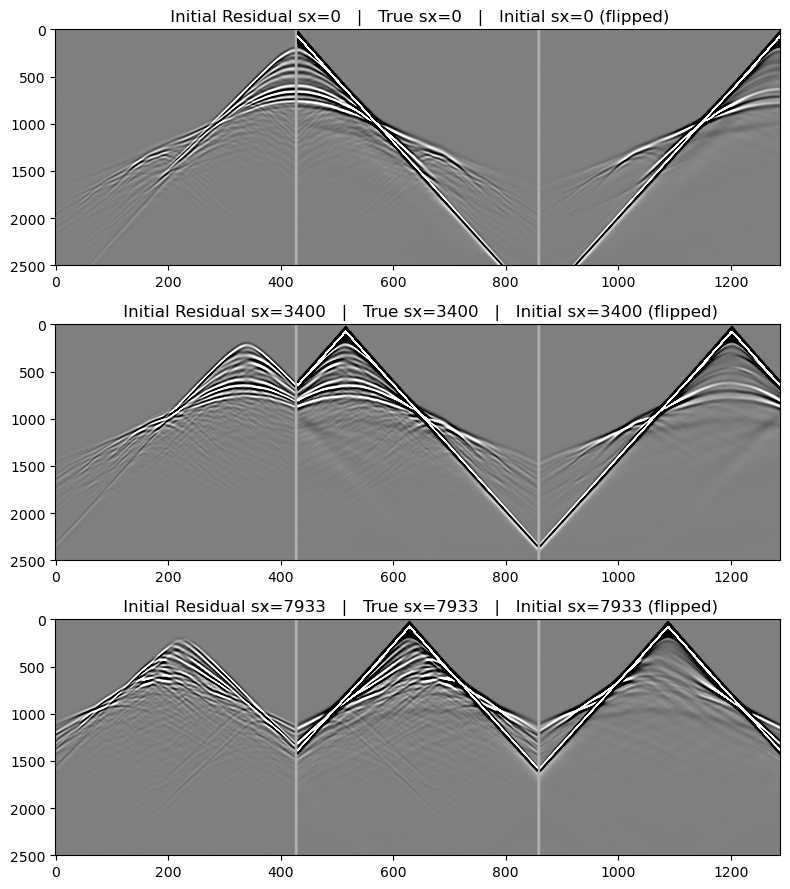

scale = 0.3693818850470227


In [18]:
scale = 2000.0 / sqrt(norm(d1local)^2 / length(d1local))
@show scale

nzero = 5
ntrec = size(io1,1)
pad = ones(Float32,ntrec,nzero)

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    cat2 = [reverse(r2local[iplot];dims=2) pad d1local[iplot] pad reverse(d2local[iplot];dims=2)] 
    subplot(3,1,iplot);
    imshow(scale .* cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sx=$(sx[ishot])   |   True sx=$(sx[ishot])   |   Initial sx=$(sx[ishot]) (flipped)");
end
tight_layout()

## 7. Assess if data is cycle skipped at the farthest offsets
Next we plot the far offset traces for these three shots in order to assess if the data is cycle skipped. 

You can ovbserve in the plots below that the refraction waveforms (first arrivals) in the initial model are not cycle skipped with respect to the true model, so we can proceed. 

A very significant part of the residual wavefield is actually reflections in this example.

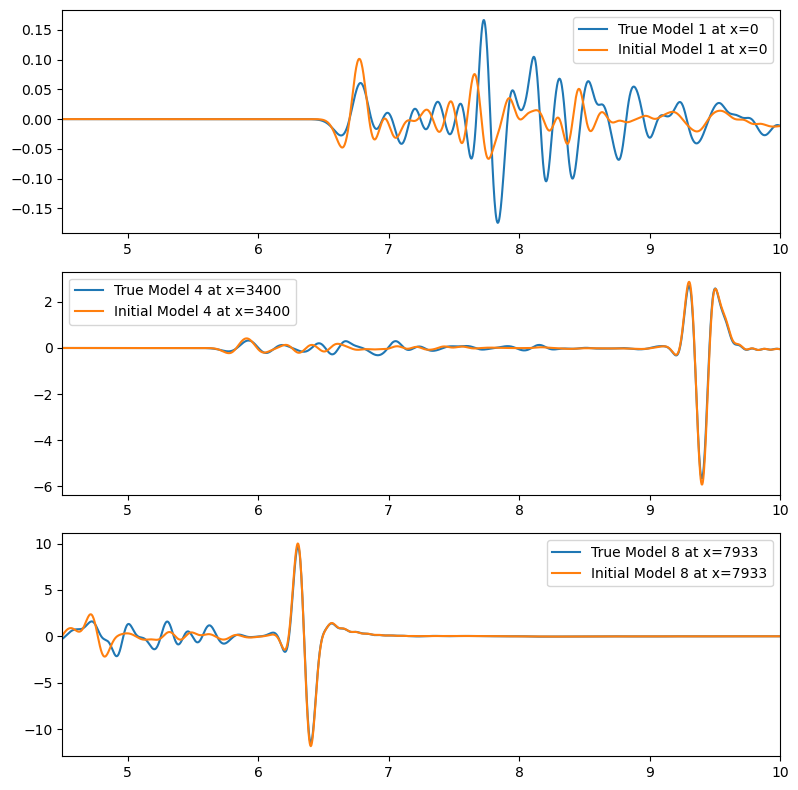

In [19]:
dtrec = pincs(io1,1)

t = [0.0:dtrec:dtrec*(ntrec - 1);]

figure(figsize=(8,8)); clf()
for (iplot,ishot) in enumerate(shots)
    subplot(3,1,iplot);
    plot(t,d1local[iplot][:,end],label="True Model $(ishot) at x=$(sx[ishot])");
    plot(t,d2local[iplot][:,end],label="Initial Model $(ishot) at x=$(sx[ishot])");
    xlim([4.5,t[end]])
    legend()
end
tight_layout()

## 8. Build the `gradient!` and `cost` functions

#### Build water bottom mask for gradient
We use this mask to remove the imprint in gradients of proximity to source locations. The mask is set to 0 wherever the true velocity model has value 1500 m/s, and is set to 1 otherwise. Without this mask most of the gradient updates would be concentrated close to sources where the model is correct. 

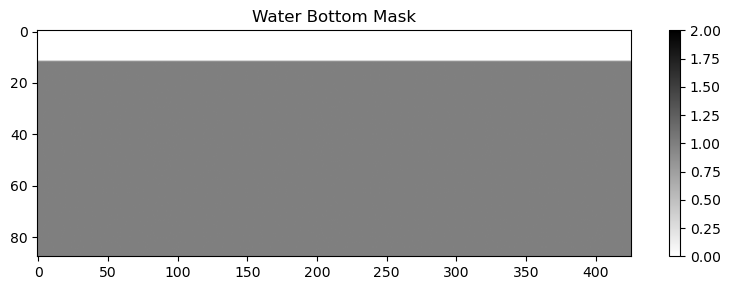

In [20]:
wb_mask = ones(Float32,size(v))
wb_mask[v.==1500.0] .= 0;

figure(figsize=(8,3))
imshow(wb_mask,aspect="auto",cmap="gray_r",clim=[0,+2]);
colorbar();
title("Water Bottom Mask");
tight_layout()

#### Build a function for the cost and gradient
This is done in a way that works well with Optim.jl.  The method wil be called by Optim.jl whenever the cost or gradient is required. If Optim requires the cost but not the gradient, then Optim will set `g` to `nothing`.  Steps in computing the gradient are as follows:
1. Apply box constraints to keep velocity inside `[vmin,vmax]`
1. Compute the source side illumination `illum`, and normalize by maximum value
1. Establish the illumination compensation preconditioner $R(x,z)$ and normalize to maximum absolute value 1. 
$$ R(x,z) = \biggl[ \sum_t s(x,z,t)^2 \biggr]^{-\alpha} $$
1. Apply the adjoint of the Jacobian to the current residual `J' * [F*v - d]` 
1. Apply the illumination compensation and the water bottom mute to the gradient
1. Rescale the gradient to have maximum absolute value 20 m/s

In [21]:
function fg_shot!(_gsϕ, i, container, _v, dz, dx)
    io = csopen(container)
    dₒ,h = readframe(io, i)
    v = localpart(_v)
    nz,nx = size(v)
    
    F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = Sys.CPU_THREADS,
        ntrec = size(io,1),
        dtrec = pincs(io,1),
        dtmod = 0.002,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=4.0),
        sx = get(prop(io, "SOU_X"), h, 1),
        sz = -get(prop(io, "SOU_ELEV"), h, 1),
        rx = [get(prop(io, "REC_X"), h, i) for i=1:size(h,2)],
        rz = [-get(prop(io, "REC_ELEV"), h, i) for i=1:size(h,2)],
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        srcfieldfile = tempname(),
        reportinterval=0)
    
    r = F*v .- dₒ
    
    ϕ = (fetch(_gsϕ).ϕ)::Ref{Float64}
    
    ϕ[] += norm(r)^2

    g = (fetch(_gsϕ).g)::Union{Nothing,Array{Float32,2}}
    if g != nothing
        s = (fetch(_gsϕ).s)::Array{Float32,2}
        J = jacobian(F, v)
        _g = J'*r
        _s = srcillum(J)
        g .+= _g
        s .+= _s
    end
    close(F)
    
    nothing
end

function fg!(f, g, s, container, v, dz, dx, wb_mask, gscale, minworkers, maxworkers)
    if g != nothing
        g .= 0
        s .= 0
    else
        s = nothing
    end
    ϕ = Ref(0.0)
    
    clamp!(v, 1377, 4689)
    _v = ArrayFutures(v)
    
    local my_zeros, my_reducer, gsϕ
    if g == nothing
        my_zeros = ()->(g=nothing,s=nothing,ϕ=Ref(0.0))
        my_reducer! = (x,y)->(x.ϕ[] += y.ϕ[]; nothing)
    else
        my_zeros = ()->(g=zeros(Float32,size(v)),s=zeros(Float32,size(v)),ϕ=Ref(0.0))
        my_reducer! = (x,y)->(x.g .+= y.g; x.s .+= y.s; x.ϕ[] += y.ϕ[]; nothing)
    end
    
    io = csopen(container)
        
    epmapreduce!((g=g,s=s,ϕ=ϕ), fg_shot!, 1:size(io,3), container, _v, dz, dx;
        epmap_addprocs = n->addprocs(scalesettemplate, n; group=scalesetname, env=Dict("OMP_PROC_BIND"=>"close", "OMP_NUM_THREADS"=>32)),
        epmap_zeros = my_zeros,
        epmap_reducer! = my_reducer!,
        epmap_init = pid->(bcast!(_v, [pid]); nothing),
        epmap_minworkers = minworkers,
        epmap_maxworkers = maxworkers,
        epmap_nworkers = nworkers_provisioned,
        epmap_scratch = AzContainer("examples/marmousi/scratch"; storageaccount=storageaccount, session=container.session))
    
    if g != nothing
        srms = sqrt(norm(s)^2 / length(s))
        s .+= eps(Float32) * srms
        s .= s.^(-4)
        s ./= maximum(s)
        g .*= wb_mask .* s
        gscale[] = gscale[] ≈ 0 ? 20 ./ maximum(g) : gscale[]
        g .*= gscale[]
    end
    
    if f != nothing
        return .5 * ϕ[]
    end
end

fg! (generic function with 1 method)

#### Compute gradient with and without illumination compensation and display

To show the importance of the illumination compensation we will compute two gradients: 
* one with `α = 0` (no illumnation compensation)
* one with `α = 4` (squared source side amplitude)

Note how the illumination compensation greatly improved the scaling of the gradient with depth.

In [ ]:
g = zeros(Float32,size(v1))
s = zeros(Float32,size(v1))

gscale = Ref(0.0)
minworkers = 0
maxworkers = 8
ϕ = fg!(true, g, s, container1, v2, dz, dx, wb_mask, gscale, minworkers, maxworkers)

In [ ]:
dv = v1 .- v2

figure(figsize=(8,9))

subplot(3,1,1)
imshow(-1 .* (g ./ s) ./ maximum(abs,g ./ s),aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(-1,1);
title("Initial Gradient without Illumination Compensation (times -1)");

subplot(3,1,2)
imshow(-1 .* g ./ maximum(abs,g),aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(-1,1);
title("Initial Gradient with Illumination Compensation (times -1)");

subplot(3,1,3)
imshow(dv ./ maximum(abs,dv),aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(-1,1);
title("Velocity Difference: (v_true - v_init)");

tight_layout()

## 9. Perform the FWI using `Optim.jl`
* We do 25 iterations of limited memory BFGS.

* Optim's initial guess supplies an initial step size to the backtracking linesearch: `LineSearches.InitialStatic()` implies that the default step size of 1 results in a change of 10 m/s in the model. 

* Note that you can change the size of the cluster (via the portal) while this runs.  Part way through the run, I change from 8 to 16 workers, and this is reflected in the output

In [22]:
function mycallback(state::OptimizationState)
    @info "iter=$(state.iteration), cost=$(state.value), |grad|=$(state.g_norm)"
    false
end
mycallback(trace::OptimizationTrace) = mycallback(trace[end]);

In [18]:
niter = 25
solver = LBFGS(m = niter, 
    alphaguess = LineSearches.InitialStatic(), 
    linesearch = LineSearches.BackTracking(order=3));

minworkers = 16
maxworkers = 8
gscale = Ref(0.0)
s = zeros(Float32,nz,nx)
_fg!(f, g, v) = fg!(f, g, s, container1, v, dz, dx, wb_mask, gscale, minworkers, maxworkers)

topt = @elapsed begin
    result = optimize(Optim.only_fg!(_fg!), v2, solver,
        Optim.Options(
            iterations = niter,
            show_trace = false,
            store_trace = true,
            show_every = 1,
            extended_trace = true,
            allow_f_increases = false,
            callback = mycallback))
end
rmprocs(workers())

[ Info: task loop...
[ Info: Provisioning scale-set...
[ Info: running task 1 on process 4; 8 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 2; 8 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 3; 8 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 7; 8 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 5; 8 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 6; 8 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 8; 8 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 9; 8 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 2; 8 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 4; 8 workers total; 6 tasks left in task-pool.
[ Info: running task 11 on process 3; 8 workers total; 5 tasks left in task-pool.
[ Info: running task 12 on process 5; 8 worker

[ Info: running task 13 on process 7; 8 workers total; 3 tasks left in task-pool.
[ Info: running task 14 on process 6; 8 workers total; 2 tasks left in task-pool.
[ Info: running task 15 on process 5; 8 workers total; 1 tasks left in task-pool.
[ Info: running task 16 on process 9; 8 workers total; 0 tasks left in task-pool.
[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: task loop...
[ Info: running task 1 on process 3; 8 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 5; 8 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 2; 8 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 9; 8 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 4; 8 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 6; 8 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 8; 8 workers total; 9 tasks left in task-pool.


[ Info: running task 12 on process 14; 16 workers total; 4 tasks left in task-pool.
[ Info: running task 13 on process 13; 16 workers total; 3 tasks left in task-pool.
[ Info: running task 14 on process 15; 16 workers total; 2 tasks left in task-pool.
[ Info: running task 15 on process 17; 16 workers total; 1 tasks left in task-pool.
[ Info: running task 16 on process 16; 16 workers total; 0 tasks left in task-pool.
[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: task loop...
[ Info: running task 1 on process 2; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 15; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 4; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 11; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 16; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 3; 16 workers total; 10 tasks

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: task loop...
[ Info: running task 1 on process 15; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 13; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 4; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 2; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 11; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 17; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 3; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 8; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 7; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 9; 16 workers total; 6 tasks left in task-pool.
[ Info: running task 11 on process 5; 16 workers total; 5 tasks left i

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: task loop...
[ Info: running task 1 on process 13; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 4; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 9; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 15; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 2; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 3; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 6; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 11; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 7; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 12; 16 workers total; 6 tasks left in task-pool.
[ Info: running task 11 on process 17; 16 workers total; 5 tasks left 

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: iter=9, cost=499980.34, |grad|=5.3098497
[ Info: task loop...
[ Info: running task 1 on process 15; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 13; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 10; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 2; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 17; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 4; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 6; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 8; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 11; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 9; 16 workers total; 6 tasks left in task-pool.
[ Info: running task

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: iter=11, cost=266444.38, |grad|=2.9550788
[ Info: task loop...
[ Info: running task 1 on process 2; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 13; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 11; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 15; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 3; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 8; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 4; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 6; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 17; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 10; 16 workers total; 6 tasks left in task-pool.
[ Info: running tas

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: iter=13, cost=202798.7, |grad|=2.3911412
[ Info: task loop...
[ Info: running task 1 on process 10; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 6; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 3; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 17; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 5; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 13; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 16; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 9; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 15; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 12; 16 workers total; 6 tasks left in task-pool.
[ Info: running tas

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: iter=15, cost=97598.57, |grad|=1.8632529
[ Info: task loop...
[ Info: running task 1 on process 2; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 9; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 10; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 4; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 6; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 12; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 16; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 13; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 15; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 7; 16 workers total; 6 tasks left in task-pool.
[ Info: running task

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: task loop...
[ Info: running task 1 on process 4; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 6; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 5; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 9; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 10; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 12; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 16; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 17; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 3; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 15; 16 workers total; 6 tasks left in task-pool.
[ Info: running task 11 on process 13; 16 workers total; 5 tasks left

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: task loop...
[ Info: running task 1 on process 15; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 10; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 6; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 2; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 11; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 3; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 13; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 4; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 17; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 16; 16 workers total; 6 tasks left in task-pool.
[ Info: running task 11 on process 14; 16 workers total; 5 tasks lef

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: task loop...
[ Info: running task 1 on process 4; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 2; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 3; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 13; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 15; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 17; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 9; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 10; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 5; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 11; 16 workers total; 6 tasks left in task-pool.
[ Info: running task 11 on process 12; 16 workers total; 5 tasks left

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: iter=21, cost=41663.42, |grad|=1.0409216
[ Info: task loop...
[ Info: running task 1 on process 15; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 3; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 13; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 2; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 11; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 4; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 17; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 16; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 9; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 12; 16 workers total; 6 tasks left in task-pool.
[ Info: running tas

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: task loop...
[ Info: running task 1 on process 13; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 2; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 17; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 4; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 3; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 10; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 6; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 8; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 9; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 15; 16 workers total; 6 tasks left in task-pool.
[ Info: running task 11 on process 11; 16 workers total; 5 tasks left 

[ Info: ...done task loop
[ Info: reduce loop...
[ Info: ...done reduce loop.
[ Info: task loop...
[ Info: running task 1 on process 4; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 2; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 8; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 3; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 13; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 10; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 11; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 6; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 17; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 9; 16 workers total; 6 tasks left in task-pool.
[ Info: running task 11 on process 15; 16 workers total; 5 tasks left 

Task (done) @0x00007f8058fec010

In [19]:
@sprintf("Time for optimization; %.2f minutes\n", topt / 60)
@info "result=\n$result\n"

┌ Info: result=
│  * Status: failure (reached maximum number of iterations)
│ 
│  * Candidate solution
│     Final objective value:     1.823455e+04
│ 
│  * Found with
│     Algorithm:     L-BFGS
│ 
│  * Convergence measures
│     |x - x'|               = 3.98e+01 ≰ 0.0e+00
│     |x - x'|/|x'|          = 8.48e-03 ≰ 0.0e+00
│     |f(x) - f(x')|         = 4.08e+03 ≰ 0.0e+00
│     |f(x) - f(x')|/|f(x')| = 2.24e-01 ≰ 0.0e+00
│     |g(x)|                 = 7.78e-01 ≰ 1.0e-08
│ 
│  * Work counters
│     Seconds run:   2458  (vs limit Inf)
│     Iterations:    25
│     f(x) calls:    38
│     ∇f(x) calls:   26
└ 


In [20]:
vf = Optim.minimizer(result) # optimal solution
clamp!(vf,vmin,vmax)         # apply the box constraints
ϕ = Optim.f_trace(result)    # cost vs iteration
m = Optim.x_trace(result);   # model vs iteration

## 10. Visualize velocity models and objective function

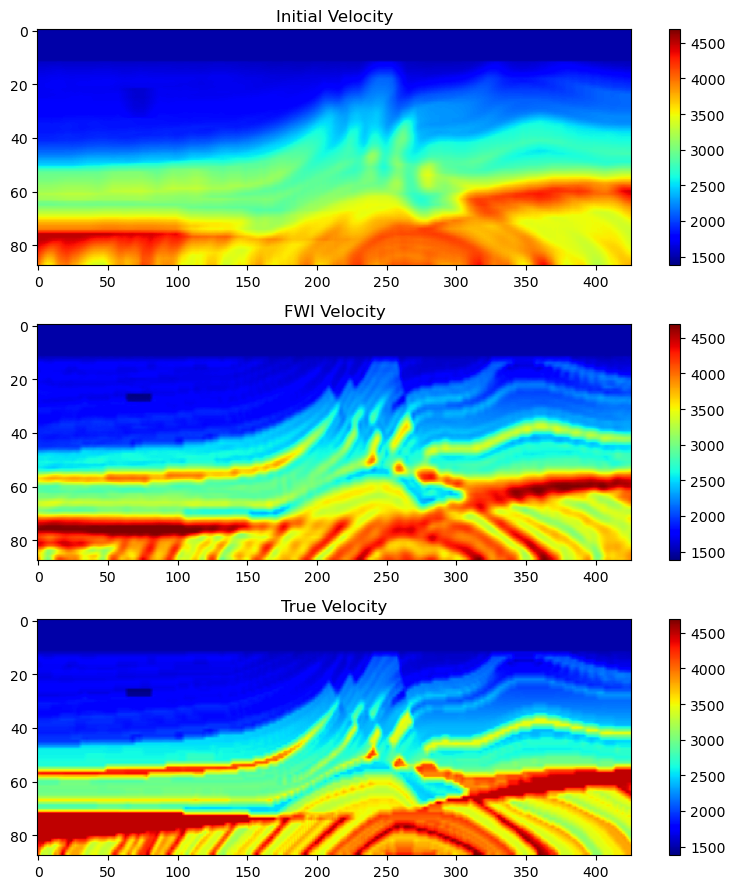

In [21]:
figure(figsize=(8,9)); clf()

subplot(3,1,1);imshow(v2,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("Initial Velocity");

subplot(3,1,2);imshow(vf,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI Velocity");

subplot(3,1,3);imshow(v1,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("True Velocity")

tight_layout()

#### Display the velocity difference models 

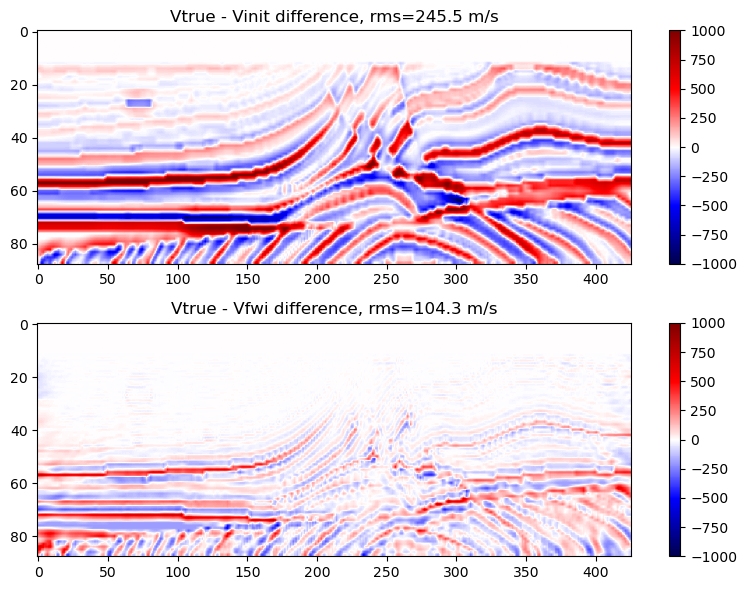

In [22]:
rms_v2 = @sprintf("%.1f m/s", sqrt(norm(v1 .- v2)^2 / length(v1)))
rms_vf = @sprintf("%.1f m/s", sqrt(norm(v1 .- vf)^2 / length(v1)))

figure(figsize=(8,6)); clf()

subplot(2,1,1);imshow(v1 .- v2,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vinit difference, rms=$(rms_v2)");

subplot(2,1,2);imshow(v1 .- vf,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vfwi difference, rms=$(rms_vf)");

tight_layout()

#### Display the cost function 

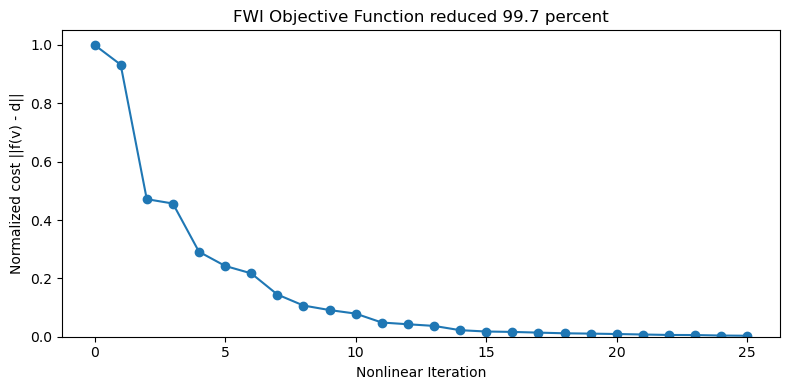

In [23]:
figure(figsize=(8,4)); clf()
iters = [0:1:length(ϕ)-1;]
plot(iters, ϕ ./ ϕ[1], marker="o")
ylim([0,1.05])
xlabel("Nonlinear Iteration")
ylabel("Normalized cost ||f(v) - d||")
title(@sprintf("FWI Objective Function reduced %.1f percent", 100 * (ϕ[1] - ϕ[end]) / ϕ[1]));
tight_layout()

#### Display data misfit vs model misfit

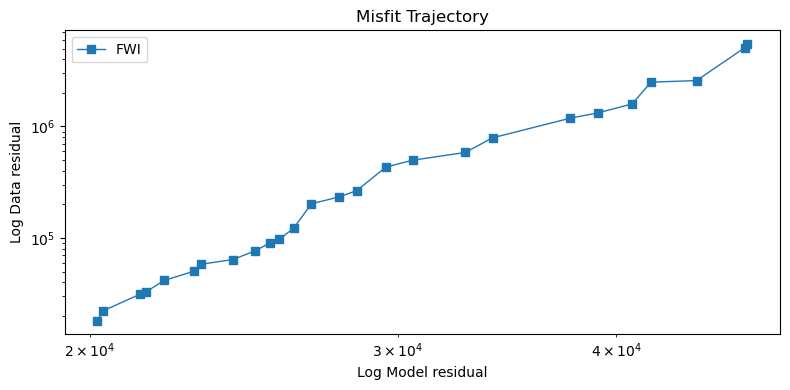

In [24]:
figure(figsize=(8,4)); clf()

c = [norm(m[i] .- v1, 2) for i in 1:length(m)]
loglog(c, ϕ, label="FWI", marker="s", linewidth=1)
legend()
xlabel("Log Model residual")
ylabel("Log Data residual")
title("Misfit Trajectory");
tight_layout()

using DelimitedFiles
open("results.g010.InitialStatic.BackTracking2.txt", "w") do io
    writedlm(io, [ϕ c])
end

## 11. Visualize data match
#### Generate data in the FWI velocity model

In [23]:
container3 = AzContainer("examples/marmousi/data-vf-cs";storageaccount=storageaccount)

AzContainer{AzSessions.AzDeviceCodeFlowSession}("samkaplan0", "examples", "marmousi/data-vf-cs", Azure device code flow credentials session, 16, 10, 0)

In [ ]:
cscreate(container3; similarto=container2)

In [ ]:
_vf = ArrayFutures(vf)
epmap(build_data, 1:length(sx), container3, sx, _vf, dz, dx;
        epmap_addprocs = n->addprocs(scalesettemplate, n; group=scalesetname),
        epmap_nworkers = nworkers_provisioned,
        epmap_minworkers = 0,
        epmap_maxworkers = 8,
        epmap_init = pid->(bcast!(_vf, [pid]); nothing))

[ Info: Provisioning scale-set...
[ Info: running task 1 on process 18; 16 workers total; 15 tasks left in task-pool.
[ Info: running task 2 on process 19; 16 workers total; 14 tasks left in task-pool.
[ Info: running task 3 on process 26; 16 workers total; 13 tasks left in task-pool.
[ Info: running task 4 on process 20; 16 workers total; 12 tasks left in task-pool.
[ Info: running task 5 on process 21; 16 workers total; 11 tasks left in task-pool.
[ Info: running task 6 on process 24; 16 workers total; 10 tasks left in task-pool.
[ Info: running task 7 on process 25; 16 workers total; 9 tasks left in task-pool.
[ Info: running task 8 on process 27; 16 workers total; 8 tasks left in task-pool.
[ Info: running task 9 on process 23; 16 workers total; 7 tasks left in task-pool.
[ Info: running task 10 on process 22; 16 workers total; 6 tasks left in task-pool.
[ Info: running task 11 on process 32; 16 workers total; 5 tasks left in task-pool.
[ Info: running task 12 on process 30; 16 wor

Worker 29 terminated.
Worker 32 terminated.
Worker 30 terminated.
Worker 28 terminated.
Worker 31 terminated.


#### Compute residuals and collect gathers for display

In [24]:
io = csopen(container3)
dflocal = [readframetrcs(io,i) for i in shots]
rflocal = [d1local[i] .- dflocal[i] for i in 1:3];

#### Plot shot gathers for true, initial model, and fwi models

The table below describes the data images below. We will flip the direction of the residual and modeled data in order to help display the match with the true data. We include the initial data as shown above for easier comparison. 

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Data<br>(flipped)</b></td>
</tr>
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Data<br>(flipped)</b></td>
</tr>
</table>

We first make a function to create the plots that we can re-use for the selected shots.

In [25]:
function make_plot(index)
    figure(figsize=(8,6)); clf()
    cat2 = hcat(reverse(r2local[index],dims=2), pad, d1local[index], pad, reverse(d2local[index],dims=2))
    catf = hcat(reverse(rflocal[index],dims=2), pad, d1local[index], pad, reverse(dflocal[index],dims=2))
    subplot(2,1,1);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sx=$(sx[index])   ||   True sx=$(sx[index])   ||   Initial sx=$(sx[index]) (flipped)");
    subplot(2,1,2);
    imshow(catf,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" FWI Residual sx=$(sx[index])   ||   True sx=$(sx[index])   ||   FWI sx=$(sx[index]) (flipped)");
    tight_layout()
end

make_plot (generic function with 1 method)

#### Data for the 1st shot, generated in the initial and FWI models

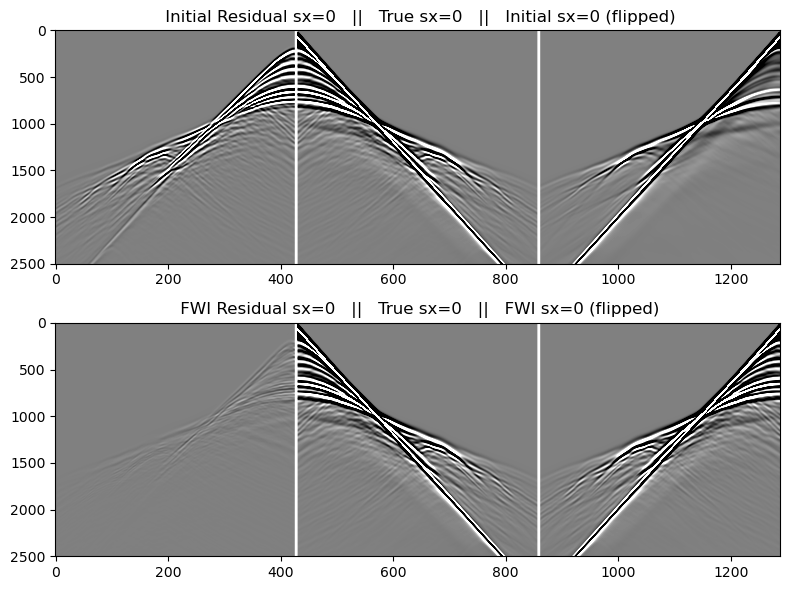

In [26]:
make_plot(1)

#### Data for the 4th shot, generated in the initial and FWI models

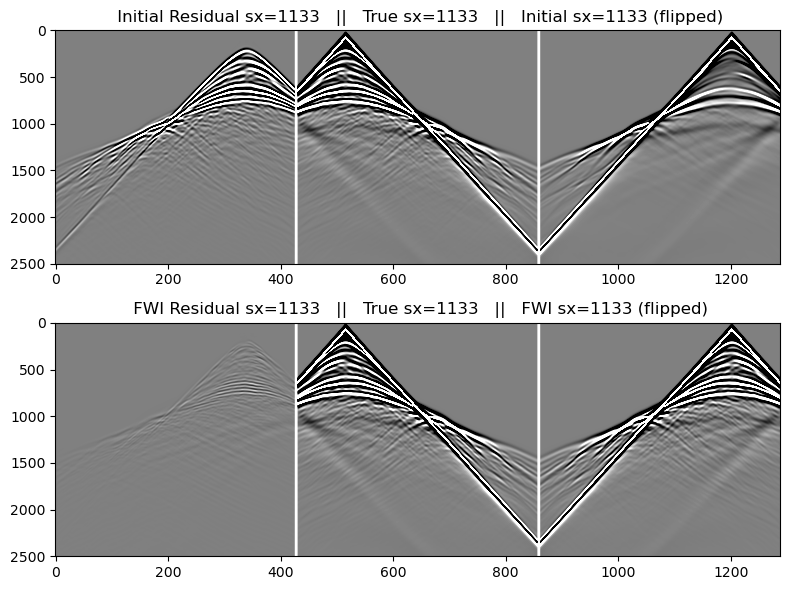

In [27]:
make_plot(2)

#### Data for the 8th shot, generated in the initial and FWI models

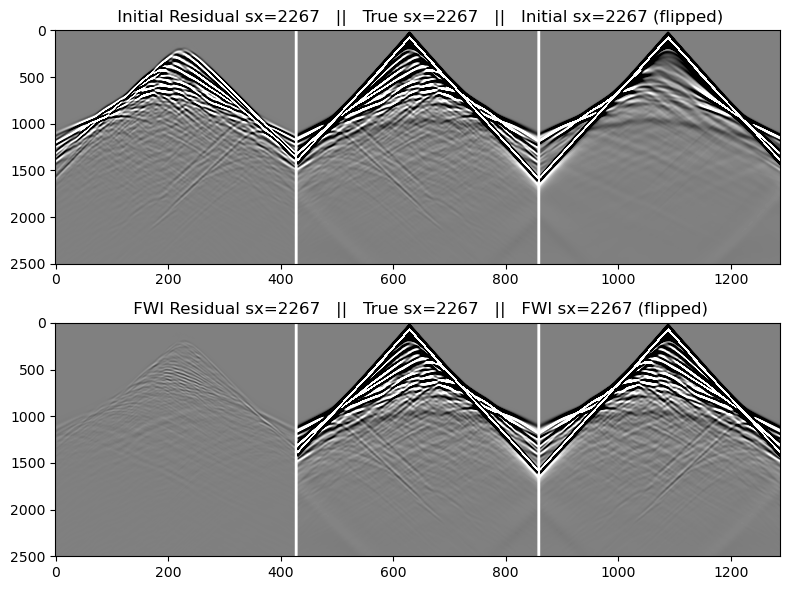

In [28]:
make_plot(3)

## 11. Write models to local disk

#### Interpolate models to 10m for subsequent RTM  

In [ ]:
@printf("nz,nx,dz,dx; %5d %5d %12.4f %12.4f\n", nz, nx, dz, dx)

z1,z2 = 0.0,dz*(nz-1)
x1,x2 = 0.0,dx*(nx-1)

dz2,dx2 = 10.0,10.0
nz2 = floor(Int,z2/dz2) + 1
nx2 = floor(Int,x2/dx2) + 1

dom = JetSpace(Float32,size(vf)...)
rng = JetSpace(Float32,nz2,nx2)
op = JopInterp(dom, rng)

v1_resamp = op * v1;
v2_resamp = op * v2;
vf_resamp = op * vf;

#### Plot the resampled models

In [ ]:
figure(figsize=(8,9)); clf()

subplot(3,1,1);imshow(v2_resamp,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("Initial Velocity (resampled to 10m)");

subplot(3,1,2);imshow(vf_resamp,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("FWI Velocity (resampled to 10m)");

subplot(3,1,3);imshow(v1_resamp,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("True Velocity (resampled to 10m)")

tight_layout()

#### Write out the models 

In [ ]:
file1 = @sprintf("marmousi_resampled_10m_%dx%d_vtrue.bin", nz2, nx2);
file2 = @sprintf("marmousi_resampled_10m_%dx%d_vinit.bin", nz2, nx2);
filef = @sprintf("marmousi_resampled_10m_%dx%d_vfwi.bin", nz2, nx2);

write(file1,v1_resamp);
write(file2,v2_resamp);
write(filef,vf_resamp);

## 12. Remove local files and workers

In [ ]:
rmprocs(workers());